In [ ]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D


In [15]:
FULL_WIDTH = 5.49064965 # width in inches for full page in thesis
plt.rcParams.update({

    "text.latex.preamble": r"\usepackage{palatino}",
    "font.family": "serif",
    "font.serif": ["Palatino"], # Fallback if LaTeX fails
    "font.size": 11,            # 11pt is standard for thesis text
    'axes.labelsize': 11,            # Axis labels (e.g., "Time (s)")
    'axes.titlesize': 12,            # (If you use titles, though you said you'd remove them)
    'figure.titlesize': 11,      # Controls supylabel and suptitle font size
    
    'xtick.labelsize': 10,           # Tick labels
    'ytick.labelsize': 10,           # Tick labels
    'legend.fontsize': 10,           
})

In [17]:
df = pd.read_csv('Data collection.csv',  header=None)
df.columns = ['path', 'into', 'question', 'iteration', 'name', 'model', 'userAnswer', 'modelAnswer', 'stringefied_prompt']
df.head()

,path,into,question,iteration,name,model,userAnswer,modelAnswer,stringefied_prompt
0,question_1/AfD-AfD/out_41-mini_v1_3.json,intro,Auf einer Skala von 1 bis 7: Wie sehr stimmst ...,0,Maxim Kallert,person_open_router_completion,6,3,"[{""role"": ""system"", ""content"": ""The scenario i..."
1,question_0/Bündnis_90_Die_Grünen-FDP/out_41-mi...,intro,Auf einer Skala von 1 bis 7: Wie sehr stimmst ...,8,Centa Zorbach,person_open_router_completion,5,5,"[{""role"": ""system"", ""content"": ""Scenario: Du d..."
2,question_1/SPD-AfD/out_41-mini_v1_0.json,intro,Auf einer Skala von 1 bis 7: Wie sehr stimmst ...,16,Bernd Textor,person_open_router_completion,6,6,"[{""role"": ""system"", ""content"": ""The scenario i..."
3,question_0/Bündnis_90_Die_Grünen-keine_Partei/...,intro,Auf einer Skala von 1 bis 7: Wie sehr stimmst ...,20,Hermann Josef Hermighausen-Stahr,person_open_router_completion,7,6,"[{""role"": ""system"", ""content"": ""Scenario: Du d..."
4,question_4/SPD-SPD/out_41-mini_v0_1.json,intro,Auf einer Skala von 1 bis 7: Wie sehr stimmst ...,0,Benita Heß,person_open_router_completion,6,6,"[{""role"": ""system"", ""content"": ""Scenario: Du d..."


In [5]:
# mean absolute error between userAnswer and modelAnswer
df['abs_error'] = (df['userAnswer'] - df['modelAnswer']).abs()
mean_abs_error = df['abs_error'].mean()
print(f'Mean Absolute Error: {mean_abs_error}')



# Wilcoxon signed-rank test to see if userAnswer and modelAnswer are significantly different
w_stat, p_value = stats.wilcoxon(df['userAnswer'], df['modelAnswer'], alternative='two-sided')
print(f'Wilcoxon statistic: {w_stat}, P-value: {p_value}')


Mean Absolute Error: 0.75
Wilcoxon statistic: 223.0, P-value: 0.03779757285767982


In [14]:
# group data by question and calculate mean absolute error for each question
grouped = df.groupby('question')['abs_error'].mean().reset_index()  



# Wilcoxon test for each question and Bonferroni correction
questions = []
ns = []
w_stats = []
p_values = []
for question, group in df.groupby('question'):
    questions.append(question)
    ns.append(len(group))
    print(f'--- Question Analysis ---')
    print(f'Question: {question}')
    print(f'length: {len(group)}')
    # require at least one non-zero difference; wilcoxon may raise if all diffs are zero or insufficient
    try:
        w_stat, p_value = stats.wilcoxon(group['userAnswer'], group['modelAnswer'], alternative='two-sided')
    except Exception:
        w_stat, p_value = (None, None)
    w_stats.append(w_stat)
    p_values.append(p_value)
    print(f'Wilcoxon statistic: {w_stat}, P-value: {p_value}')
    print('Mean Absolute Error:', group['abs_error'].mean())
    print('---')

# Bonferroni correction
num_tests = len([p for p in p_values if p is not None])
p_bonf = [min(p * num_tests, 1.0) if p is not None else None for p in p_values]
significant = [(p_adj is not None) and (p_adj < 0.05) for p_adj in p_bonf]
results_df = pd.DataFrame({
    'question': questions,
    'n': ns,
    'wilcoxon_stat': w_stats,
    'p_value': p_values,
    'p_bonferroni': p_bonf,
    'significant_bonferroni': significant
})
print('\nBonferroni-corrected results (alpha=0.05):')
print(results_df.sort_values('p_bonferroni'))


--- Question Analysis ---
Question: Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Auf allen Autobahnen soll ein generelles Tempolimit gelten. Antworte nur mit einer Zahl.
length: 16
Wilcoxon statistic: 4.0, P-value: 0.012613437305241745
Mean Absolute Error: 0.8125
---
--- Question Analysis ---
Question: Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen. Antworte nur mit einer Zahl.
length: 12
Wilcoxon statistic: 4.0, P-value: 0.125
Mean Absolute Error: 0.5833333333333334
---
--- Question Analysis ---
Question: Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Deutschland soll seine Verteidigungsausgaben erhöhen. Antworte nur mit einer Zahl.
length: 15
Wilcoxon statistic: 25.0, P-value: 0.7911530821281239
Mean Absolute Error: 0.9333333333333333
---
--- Question Analysis ---
Question: Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Die Förderung von Wi

In [12]:

QUESTIONS_SHORT_EN = [
    "Speed Limit",
    "Defence Spending",
    "Voting Age 16",
    "Wind Energy",
    "Rent Control",
]


question_mapping = {
    'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Auf allen Autobahnen soll ein generelles Tempolimit gelten. Antworte nur mit einer Zahl.': QUESTIONS_SHORT_EN[0],
    'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Deutschland soll seine Verteidigungsausgaben erhöhen. Antworte nur mit einer Zahl.': QUESTIONS_SHORT_EN[1],
    'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen. Antworte nur mit einer Zahl.': QUESTIONS_SHORT_EN[2],
    'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Die Förderung von Windenergie soll beendet werden. Antworte nur mit einer Zahl.': QUESTIONS_SHORT_EN[3],
    'Auf einer Skala von 1 bis 7: Wie sehr stimmst du der Aussage zu: Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden. Antworte nur mit einer Zahl.': QUESTIONS_SHORT_EN[4],
}

df_plot = df.copy()
df_plot['question'] = df_plot['question'].map(question_mapping)

['Defence Spending' 'Speed Limit' 'Rent Control' 'Wind Energy'
 'Voting Age 16']


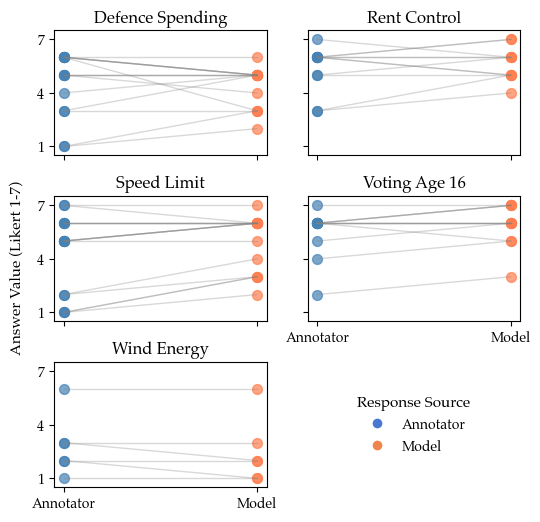

In [13]:
# Paired dot plot: connecting annotator and model answers for each observation
FULL_WIDTH  = 5.49064965

palette = sns.color_palette("muted")
color_annot = palette[0]  # e.g. Blue
color_model = palette[1]  # e.g. Orange


fig, axes = plt.subplots(3, 2, figsize=(FULL_WIDTH, FULL_WIDTH), sharex=True, sharey=True)
axes = axes.flatten()

print(df_plot['question'].unique())
questions_unique = sorted(df_plot['question'].unique())
axes_flat = axes.flatten()

for idx, question in enumerate(questions_unique):
    question_data = df_plot[df_plot['question'] == question].reset_index(drop=True)
    
    # Plot lines connecting userAnswer to modelAnswer
    for i, row in question_data.iterrows():
        axes_flat[idx].plot([0, 1], [row['userAnswer'], row['modelAnswer']], 
                       color='gray', alpha=0.3, linewidth=1)
    
    # Plot dots for annotator answers (left)
    axes_flat[idx].scatter([0] * len(question_data), question_data['userAnswer'], 
                     label='Annotator', alpha=0.7, s=50, color='steelblue')
    
    # Plot dots for model answers (right)
    axes_flat[idx].scatter([1] * len(question_data), question_data['modelAnswer'], 
                     label='Model', alpha=0.7, s=50, color='coral')
    
    axes_flat[idx].set_xticks([0, 1])
    axes_flat[idx].set_xticklabels(['Annotator', 'Model'])
    axes_flat[idx].set_title(question)
    axes_flat[idx].set_ylim(0.5, 7.5)
    axes_flat[idx].set_yticks([1,4,7])
    # axes_flat[idx].grid(axis='y', alpha=0.3)
    
# 3. Handle the "Gap"
# Ensure the bottom-left plot (index 3) shows x-labels
axes[3].tick_params(labelbottom=True)
axes[3].xaxis.set_visible(True)

# 4. Legend (Placed in the empty 6th subplot)
legend_ax = axes[5]
legend_ax.axis("off")

# We create custom handles because we scattered twice
custom_lines = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_annot, markersize=8, label='Annotator'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_model, markersize=8, label='Model')
]

legend_ax.legend(
    title="Response Source",
    handles=custom_lines,
    loc="center", 
    frameon=False, 
    fontsize=10
)

# 5. Super Labels
fig.supylabel("Answer Value (Likert 1-7)", size=11)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, left=0.1)

plt.savefig(f"figures/sanity_check_paired_plot.pdf", bbox_inches="tight")
plt.show()


# print the size of the supylabel


In [9]:
# Iterate through all text objects in the figure
for text_obj in fig.texts:
    print(f"Text: {text_obj.get_text()}, Font size: {text_obj.get_fontsize()}")

Text: Answer Value (Likert 1-7), Font size: 11.0
